In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import visualization
from utils.simulations import *
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
folder_path = './dataset/Simulations_6_indep/'  # change to your folder path
file_names = os.listdir(folder_path)
results_kmdist = []
results_logrank = []
# Display the file names
for name in file_names:
    if 'results_log_rank' in name:
        print(name)
        results_logrank.append(pd.read_csv(folder_path + name,index_col=0))
    if 'results_complete_survival_km_distance' in name:
    # if 'results_survival_km_distance' in name:
        print(name)
        results_kmdist.append(pd.read_csv(folder_path + name,index_col=0))
results_kmdist = pd.concat(results_kmdist)
results_kmdist = results_kmdist.sort_values(by='XP_num')

results_complete_survival_km_distance_n_samples_600_n_features_bytype_6_MC_21to30.csv
results_complete_survival_km_distance_n_samples_600_n_features_bytype_6_MC_41to50.csv
results_complete_survival_km_distance_n_samples_600_n_features_bytype_6_MC_61to70.csv
results_complete_survival_km_distance_n_samples_600_n_features_bytype_6_MC_81to90.csv
results_complete_survival_km_distance_n_samples_600_n_features_bytype_6_MC_31to40.csv
results_complete_survival_km_distance_n_samples_600_n_features_bytype_6_MC_11to20.csv
results_complete_survival_km_distance_n_samples_600_n_features_bytype_6_MC_71to80.csv
results_complete_survival_km_distance_n_samples_600_n_features_bytype_6_MC_51to60.csv
results_complete_survival_km_distance_n_samples_600_n_features_bytype_6_MC_91to100.csv
results_complete_survival_km_distance_n_samples_600_n_features_bytype_6_MC_1to10.csv


In [3]:
# # folder_path = './dataset/Simulations_4/'  # change to your folder path
# results_kmdist = pd.read_csv(folder_path + 'results_survival_km_distance_n_samples_600_n_features_bytype_6.csv', index_col=0)
# results_kmdist = results_kmdist.sort_values(by='XP_num')

In [4]:
results_kmdist_ext = results_kmdist.copy(deep=True)
treat_effects = np.unique(results_kmdist_ext.H0_coef.values)
generators_sel = ["HI-VAE_weibull", "HI-VAE_weibull_prior", "HI-VAE_piecewise", "HI-VAE_piecewise_prior", "Surv-GAN", "Surv-VAE"] 
# generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"] 

In [5]:
for col in results_kmdist_ext.columns:
    results_kmdist_ext[col] = np.float64(results_kmdist_ext[col].values)

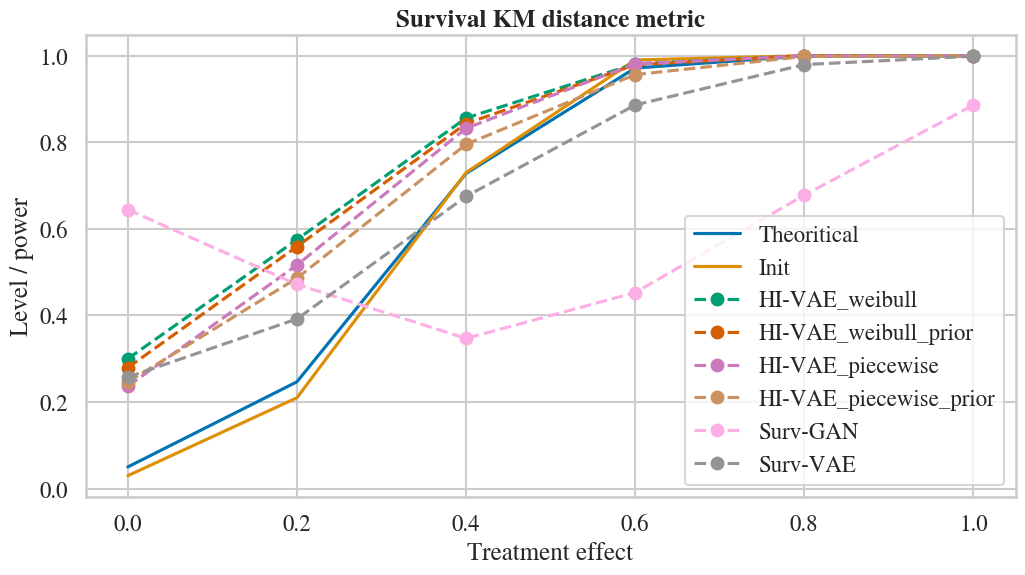

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
H0_coef_univ_theo = results_kmdist_ext.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_treated"].to_numpy()
power_theo = []
for i in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[i], D_treated_theo[i], H0_coef_univ_theo[i], 0.05))
ax.plot(treat_effects, np.array(power_theo), label = "Theoritical")

results_kmdist_ext["reject_H0_init"] = results_kmdist_ext['log_pvalue_init'] > -np.log(0.05)
power_init = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
ax.plot(treat_effects, power_init, '-', label = "Init")

custom_palette = ['deepskyblue','darkblue','orange', 'red']
for i, generator_name in enumerate(generators_sel):
    results_kmdist_ext["reject_H0_gen_" + generator_name] = results_kmdist_ext['log_pvalue_' + generator_name] > -np.log(0.05)
    power_gen = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
    ax.plot(treat_effects, power_gen, '--', marker='o', label = generator_name,)

plt.xlabel("Treatment effect")
plt.ylabel("Level / power")
plt.title("Survival KM distance metric", fontweight='semibold')
plt.legend()
plt.show()
# plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

In [8]:
H0_coef_univ_theo = results_kmdist_ext.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_treated"].to_numpy()
power_theo = []
for i in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[i], D_treated_theo[i], H0_coef_univ_theo[i], 0.05))

# results_logrank_ext["reject_H0_init"] = results_logrank_ext['log_pvalue_init'] > -np.log(0.05)
power_init = results_kmdist_ext.groupby(["XP_num", "H0_coef"]).mean().reset_index()
power_init_sel = power_init[["H0_coef"]]
power_init_sel["log_pvalue"] = power_init["log_pvalue_init"]
power_init_sel["Method"] = "Init"
power_gen_df = pd.DataFrame()
for i, generator_name in enumerate(generators_sel):
    # results_logrank_ext["reject_H0_gen_" + generator_name] = results_logrank_ext['log_pvalue_' + generator_name] > -np.log(0.05)
    power_gen = results_kmdist_ext.groupby(["XP_num", "H0_coef"]).mean().reset_index()
    power_gen_sel = power_gen[["H0_coef"]]
    power_gen_sel["log_pvalue"] = power_gen["log_pvalue_" + generator_name]
    power_gen_sel["Method"] = generator_name
    power_gen_df = pd.concat([power_gen_df, power_gen_sel])
power_df = pd.concat([power_init_sel, power_gen_df])

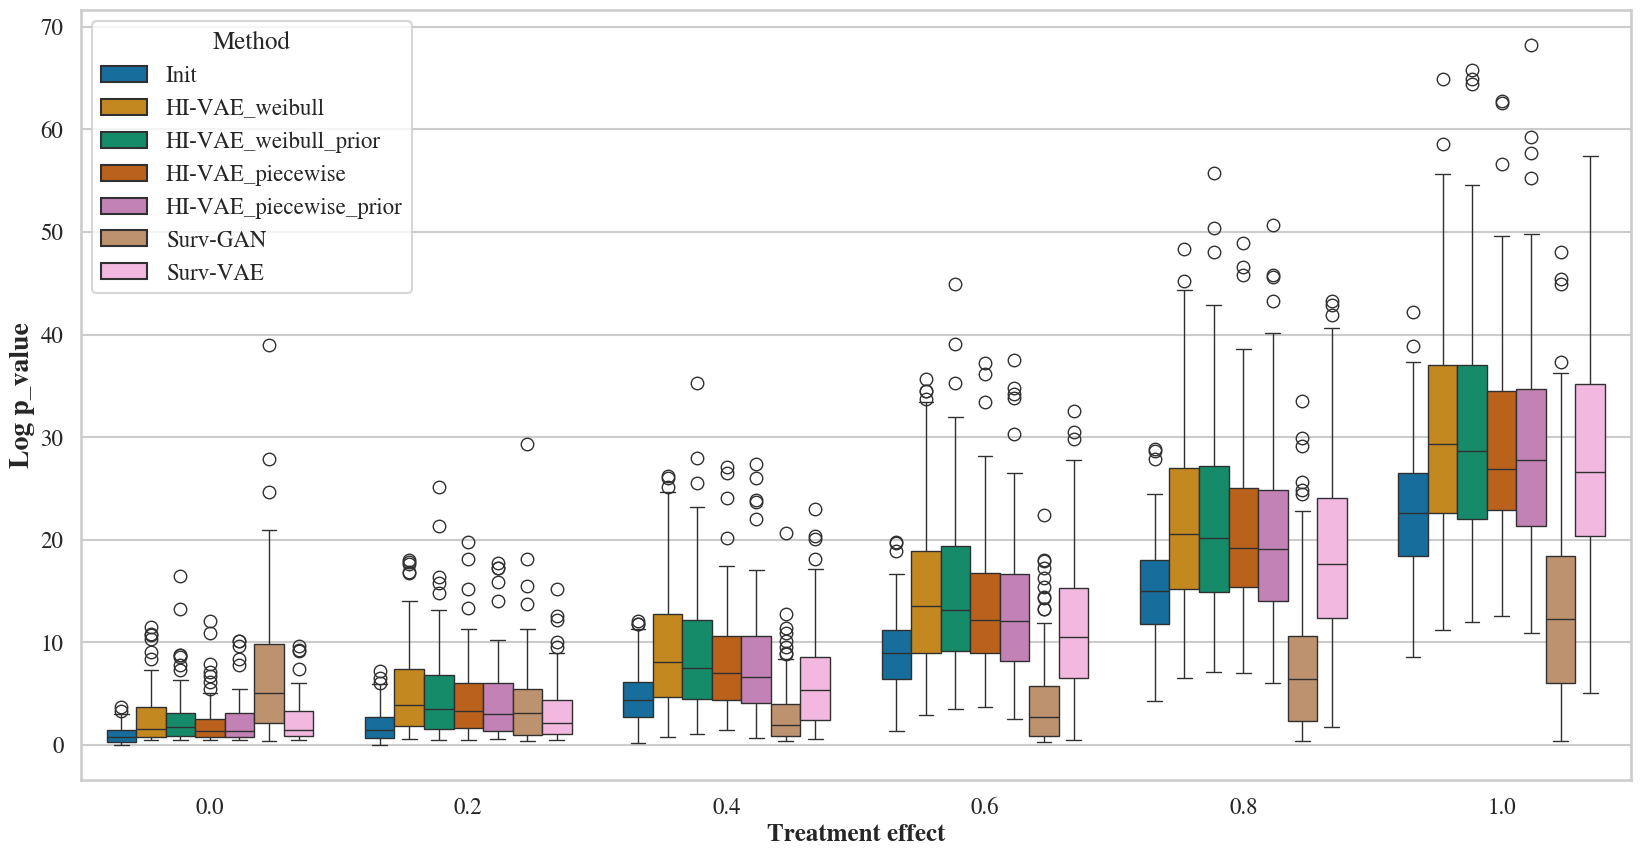

In [9]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='H0_coef', y='log_pvalue', hue="Method", data=power_df)
# plt.ylim(-0.5, 1.5)
plt.xticks(ticks=np.arange(len(treat_effects)), labels=[str(int(te * 100) / 100) for te in treat_effects])
plt.xlabel('Treatment effect', fontweight="semibold")
plt.ylabel("Log p_value", fontsize=20, fontweight="semibold")
plt.show()

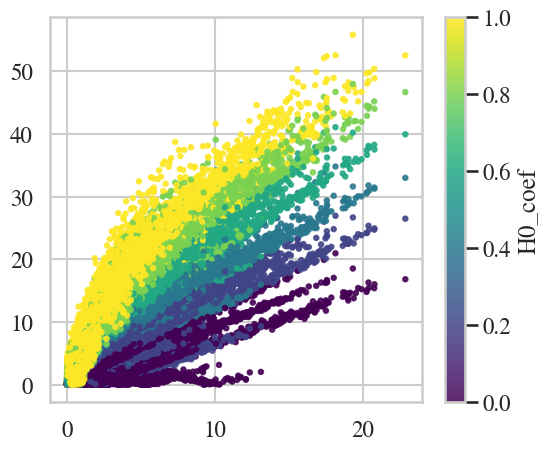

In [10]:
results_kmdist_ext.head()

fig, ax = plt.subplots(figsize=(6, 5))

sc = ax.scatter(
        results_kmdist_ext['log_pvalue_control_HI-VAE_weibull'],
        np.abs(results_kmdist_ext['log_pvalue_HI-VAE_weibull'] - results_kmdist_ext['log_pvalue_init']),
        c=results_kmdist_ext['H0_coef'],            # <-- colour by this column
        cmap='viridis',                             # any continuous colormap you like
        s=10,                                       # marker size (optional)
        alpha=0.85                                  # slight transparency (optional)
)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('H0_coef')  # This is your color "legend"

In [11]:
from scipy.stats import norm

def f_and_fprime(x, coef_univ, n, d):
    """
    Compute f(x) and f'(x) for
        f(x) = 1 - Φ(Φ⁻¹(1 - x/2) - A)
               + Φ(-Φ⁻¹(1 - x/2) - A)

    Parameters
    ----------
    x : float or array-like
        Value(s) in (0, 2)  – note the domain restriction for Φ⁻¹(1−x/2).
    theta : float > 0
    n, d : positive numbers
    
    Returns
    -------
    f      : ndarray
        Function value(s) at x.
    fprime : ndarray
        Derivative value(s) at x.
    """
    x = np.asarray(x, dtype=float)
    if np.any((x <= 0) | (x >= 1)):
        raise ValueError("x must lie strictly between 0 and 1.")
    
    # Pre-compute constants
    A = coef_univ * np.sqrt(n * d / 4)

    # z = Φ⁻¹(1 - x/2)
    z = norm.ppf(1.0 - x / 2.0)
    
    # pdf and cdf evaluations
    phi_z_minus_A = norm.pdf(z - A)
    phi_z_plus_A  = norm.pdf(z + A)
    Phi_z_minus_A = norm.cdf(z - A)
    Phi_minus_z_minus_A = norm.cdf(-z - A)
    
    # Function value
    f = 1.0 - Phi_z_minus_A + Phi_minus_z_minus_A
    
    # Derivative:  (φ(z-A) + φ(z+A)) / (2 φ(z))
    fprime = (phi_z_minus_A + phi_z_plus_A) / (2.0 * norm.pdf(z))
    
    return f, fprime

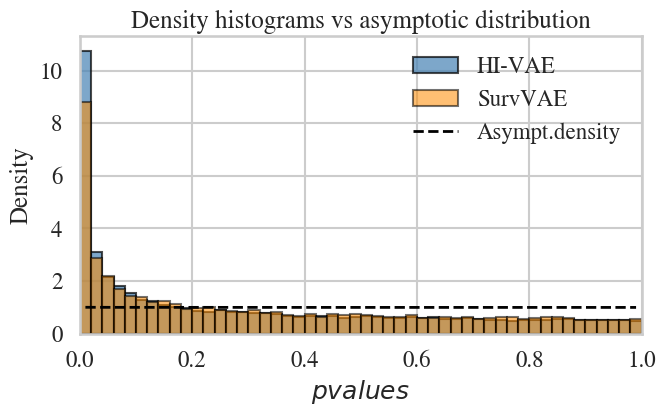

In [12]:
# print(results_kmdist_ext['H0_coef'].unique())
theta = results_kmdist_ext['H0_coef'].unique()[0]
results_kmdist_ext_H0 = results_kmdist_ext[results_kmdist_ext['H0_coef']==theta]
coef_univ = results_kmdist_ext_H0['H0_coef_univ'].to_numpy()[0]    
# --- 1. Data -----------------------------------------------------------
d1 = np.exp(-results_kmdist_ext_H0['log_pvalue_HI-VAE_weibull'])
d2 = np.exp(-results_kmdist_ext_H0['log_pvalue_Surv-VAE'])

# --- 2. Common bin edges (30 bins up to 10, adjust if needed) ----------
x_max = 1
bins  = np.linspace(0, x_max, 51)

# --- 3. Figure ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4.5))

# Histograms as densities
ax.hist(d1, bins=bins, color='steelblue',  edgecolor='black',
        alpha=0.70, label='HI-VAE', density=True)
ax.hist(d2, bins=bins, color='darkorange', edgecolor='black',
        alpha=0.55, label='SurvVAE',density=True)

# --- 4. Overlay Exp(1) density ----------------------------------------
x  = np.linspace(0.01, x_max-0.01, 400)
f,fprime = f_and_fprime(x, coef_univ, 600, 0.85)
ax.plot(x,fprime,lw=2, color='black', ls='--', label=r'Asympt.density')

# --- 5. Cosmetics ------------------------------------------------------
ax.set_xlim(0, x_max)
ax.set_ylim(bottom=0)
ax.set_xlabel(r'$pvalues$')
ax.set_ylabel('Density')
ax.set_title('Density histograms vs asymptotic distribution')
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

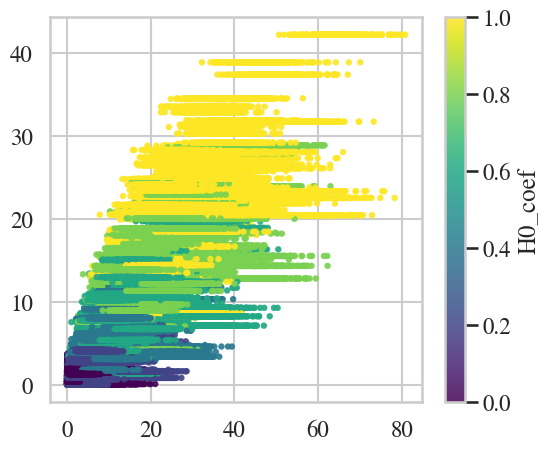

In [13]:
results_kmdist_ext.head()
fig, ax = plt.subplots(figsize=(6, 5))

sc = ax.scatter(results_kmdist_ext['log_pvalue_HI-VAE_weibull'] , results_kmdist_ext['log_pvalue_init'],
        c=results_kmdist_ext['H0_coef'],            # <-- colour by this column
        cmap='viridis',                             # any continuous colormap you like
        s=10,                                       # marker size (optional)
        alpha=0.85                                  # slight transparency (optional)
)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('H0_coef')  # This is your color "legend"

### Visualize only best generated control dataset for each MC experiment

#### Based on the minimum survival curves distance

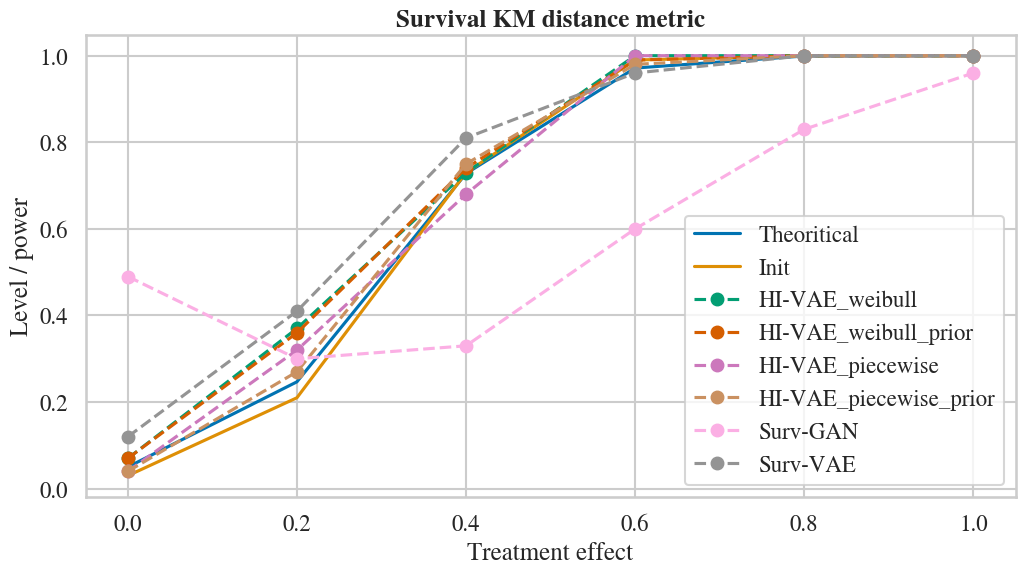

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
H0_coef_univ_theo = results_kmdist_ext.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_treated"].to_numpy()
power_theo = []
for i in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[i], D_treated_theo[i], H0_coef_univ_theo[i], 0.05))
ax.plot(treat_effects, np.array(power_theo), label = "Theoritical")

results_kmdist_ext["reject_H0_init"] = results_kmdist_ext['log_pvalue_init'] > -np.log(0.05)
power_init = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
ax.plot(treat_effects, power_init, '-', label = "Init")

custom_palette = ['deepskyblue','darkblue','orange', 'red']
XP_num = np.unique(results_kmdist_ext["XP_num"].values)

for generator_name in generators_sel:
    results_MC_best_list = []
    for m in XP_num:
        results_MC = results_kmdist_ext[results_kmdist_ext["XP_num"] == m]
        best_metric = np.min(results_MC["Survival curves distance_" + generator_name].values)
        results_MC_best = results_MC[results_MC["Survival curves distance_" + generator_name] == best_metric].copy(deep=True)
        results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
        results_MC_best_list.append(results_MC_best)
    power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
    ax.plot(treat_effects, power_gen, '--', marker='o', label = generator_name,)

# for i, generator_name in enumerate(generators_sel):
#     results_kmdist_ext["reject_H0_gen_" + generator_name] = results_kmdist_ext['log_pvalue_' + generator_name] > -np.log(0.05)
#     power_gen = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
#     ax.plot(treat_effects, power_gen, '--', marker='o', label = generator_name,)

plt.xlabel("Treatment effect")
plt.ylabel("Level / power")
plt.title("Survival KM distance metric", fontweight='semibold')
plt.legend()
plt.show()
# plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

#### Based on the minimum log(p_value) between generated control and intial control

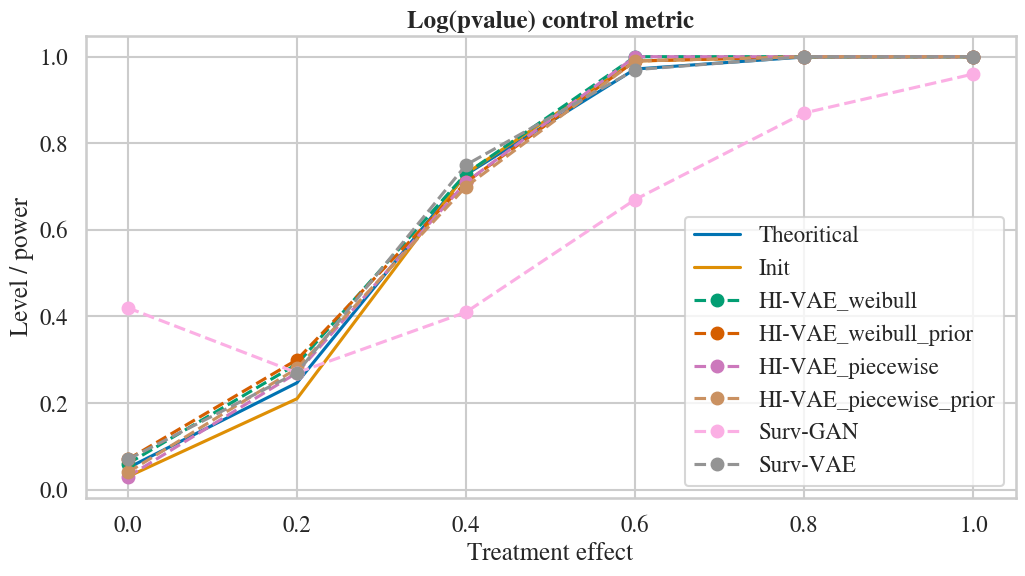

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
H0_coef_univ_theo = results_kmdist_ext.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_treated"].to_numpy()
power_theo = []
for i in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[i], D_treated_theo[i], H0_coef_univ_theo[i], 0.05))
ax.plot(treat_effects, np.array(power_theo), label = "Theoritical")

results_kmdist_ext["reject_H0_init"] = results_kmdist_ext['log_pvalue_init'] > -np.log(0.05)
power_init = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
ax.plot(treat_effects, power_init, '-', label = "Init")

custom_palette = ['deepskyblue','darkblue','orange', 'red']
XP_num = np.unique(results_kmdist_ext["XP_num"].values)

for generator_name in generators_sel:
    results_MC_best_list = []
    for m in XP_num:
        results_MC = results_kmdist_ext[results_kmdist_ext["XP_num"] == m]
        best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values)
        results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
        results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
        results_MC_best_list.append(results_MC_best)
    power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
    ax.plot(treat_effects, power_gen, '--', marker='o', label = generator_name,)

# for i, generator_name in enumerate(generators_sel):
#     results_kmdist_ext["reject_H0_gen_" + generator_name] = results_kmdist_ext['log_pvalue_' + generator_name] > -np.log(0.05)
#     power_gen = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
#     ax.plot(treat_effects, power_gen, '--', marker='o', label = generator_name,)

plt.xlabel("Treatment effect")
plt.ylabel("Level / power")
plt.title("Log(pvalue) control metric", fontweight='semibold')
plt.legend()
plt.show()
# plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

### Synthcity metrics

In [16]:
def visualize_synthcity_metric_res(results, metrics, title):
    num_metrics = len(metrics)
    n_learners = len(generators_sel)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5 * num_metrics * n_learners, 10))

    if num_metrics == 1:
        axs = [axs]  # ensure axs is iterable

    for i, ax in enumerate(axs):
        # Format axis spines
        metric_name, opt = metrics[i]
        metric_df = pd.DataFrame()
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results.shape[0], 
                                                            results[metric_name + "_" + generator_name]]).T,
                                                            columns=['generator', metric_name])])
        metric_df[metric_name] = np.float64(metric_df[metric_name].values)
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor('black')

        sns.boxplot(data=metric_df, x='generator', y=metric_name, ax=ax,
                    linewidth = 3, saturation = 1, palette = 'colorblind', 
                    width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
        ax.set_xlabel('')
        ax.set_ylabel(metric_name, fontsize=30, fontweight="semibold")
        ax.tick_params(axis='x', labelsize=25)
        ax.tick_params(axis='y', labelsize=25)
        if opt == "max":
            ax.legend(title='Maximize \u2191', title_fontsize=15)
        else:
            ax.legend(title='Minimize \u2193', title_fontsize=15)
    plt.tight_layout(pad=3)
    fig.suptitle(title, fontsize=35, fontweight='semibold')

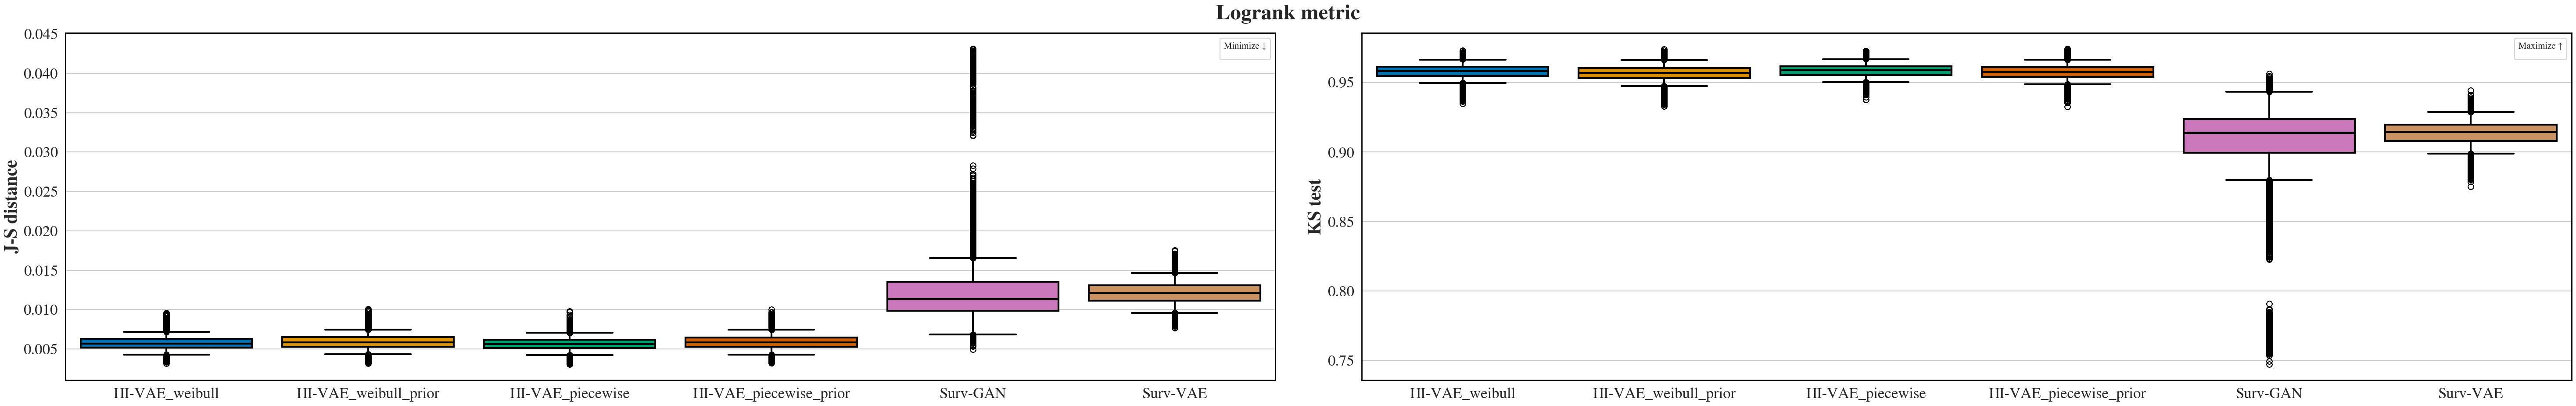

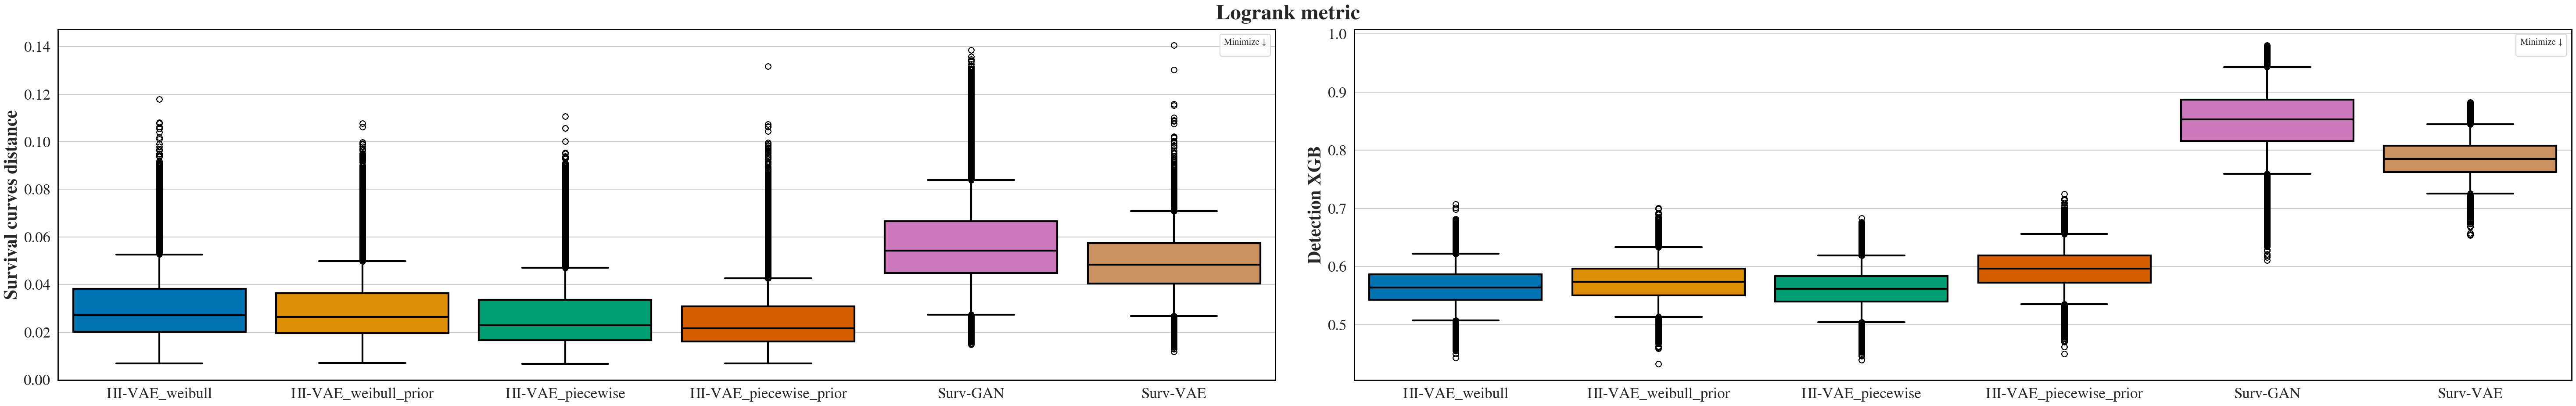

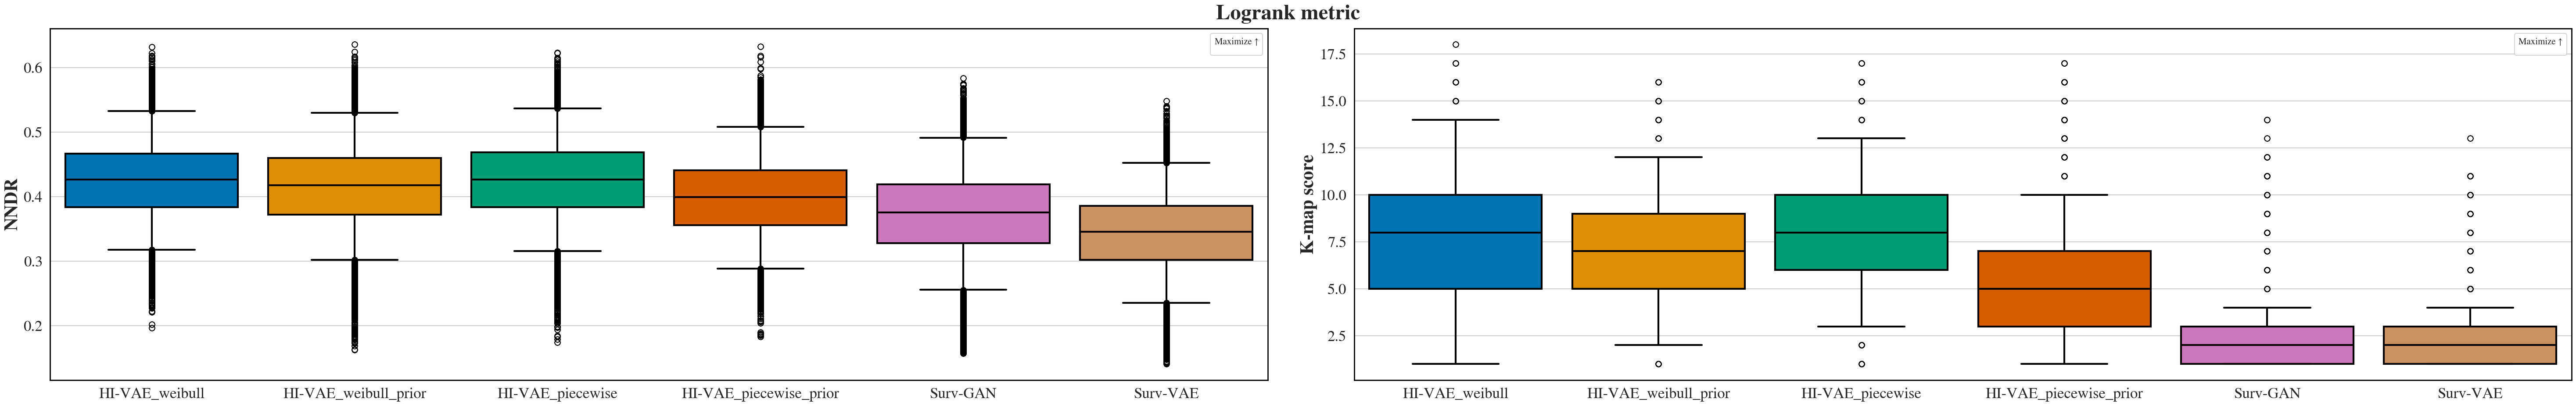

In [17]:
#### SYNTHCITY METRICS 
for metrics in [[['J-S distance', "min"], ['KS test', "max"]],
                [['Survival curves distance', "min"], ['Detection XGB', "min"]],
                [['NNDR', "max"], ['K-map score', "max"]]]:
    visualize_synthcity_metric_res(results_kmdist, metrics, 'Logrank metric')

### Visualize only best generated control dataset for each MC experiment

In [18]:
def visualize_synthcity_metric_res_ext(results, metrics, title):
    num_metrics = len(metrics)
    n_learners = len(generators_sel)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5 * num_metrics * n_learners, 10))

    if num_metrics == 1:
        axs = [axs]  # ensure axs is iterable

    for i, ax in enumerate(axs):
        # Format axis spines
        metric_name, opt = metrics[i]
        metric_df = pd.DataFrame()
        XP_num = np.unique(results["XP_num"].values)
        for m in XP_num:
            results_MC = results[results["XP_num"] == m]
            for generator_name in generators_sel:
                best_metric = np.min(results_MC["Survival curves distance_" + generator_name].values)
                results_MC_best = results_MC[results_MC["Survival curves distance_" + generator_name] == best_metric]
                metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results_MC_best.shape[0], 
                                                                results_MC_best[metric_name + "_" + generator_name]]).T,
                                                                columns=['generator', metric_name])])
        metric_df[metric_name] = np.float64(metric_df[metric_name].values)
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor('black')

        sns.boxplot(data=metric_df, x='generator', y=metric_name, ax=ax,
                    linewidth = 3, saturation = 1, palette = 'colorblind', 
                    width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
        ax.set_xlabel('')
        ax.set_ylabel(metric_name, fontsize=30, fontweight="semibold")
        ax.tick_params(axis='x', labelsize=25)
        ax.tick_params(axis='y', labelsize=25)
        if opt == "max":
            ax.legend(title='Maximize \u2191', title_fontsize=15)
        else:
            ax.legend(title='Minimize \u2193', title_fontsize=15)
    plt.tight_layout(pad=3)
    fig.suptitle(title, fontsize=35, fontweight='semibold')

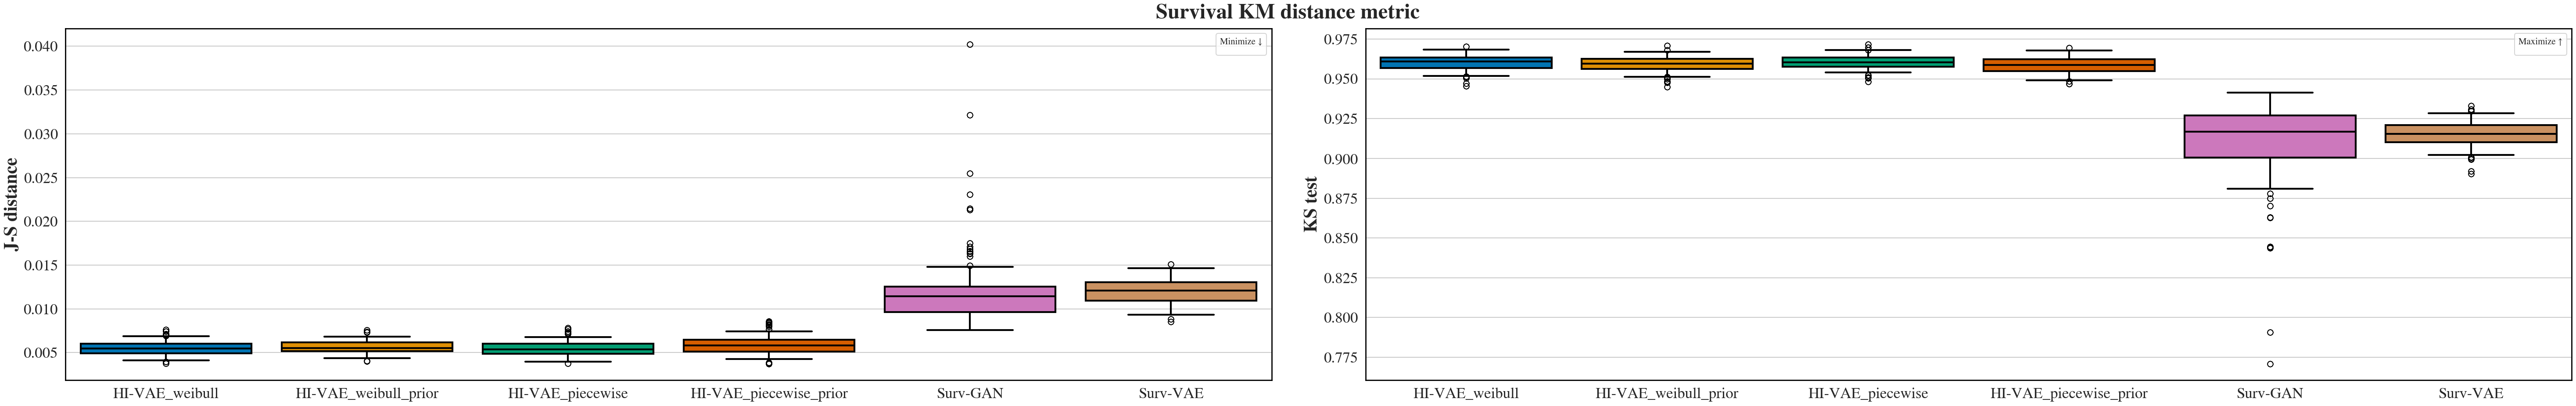

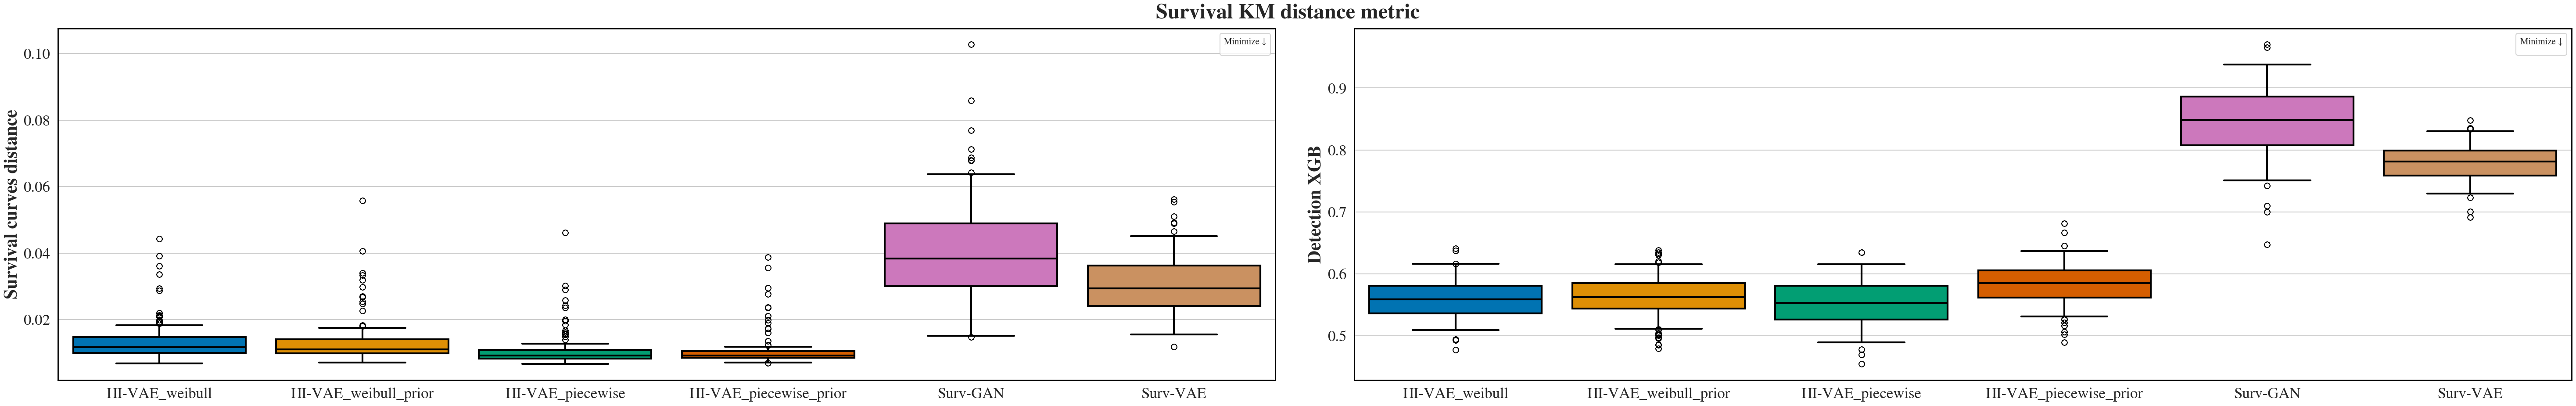

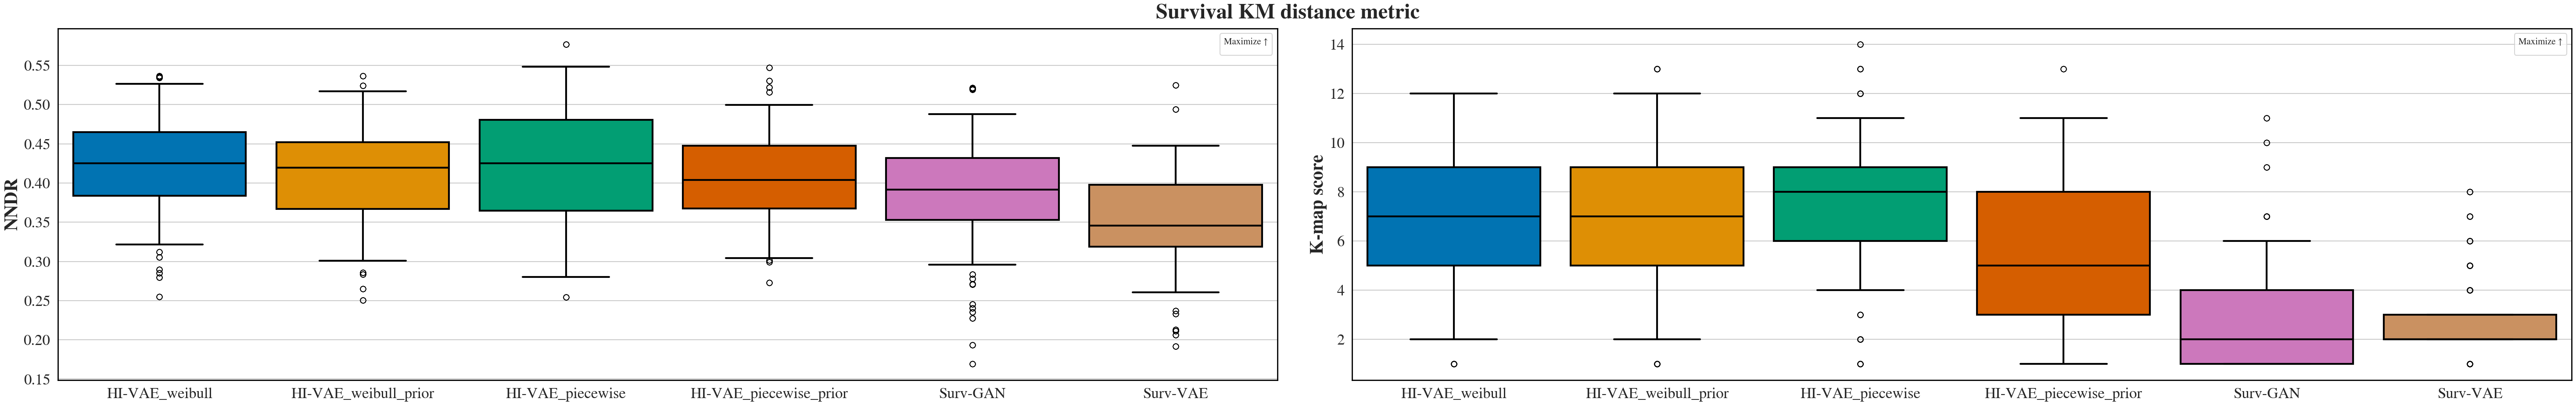

In [19]:
for metrics in [[['J-S distance', "min"], ['KS test', "max"]],
                [['Survival curves distance', "min"], ['Detection XGB', "min"]],
                [['NNDR', "max"], ['K-map score', "max"]]]:
    visualize_synthcity_metric_res_ext(results_kmdist, metrics, 'Survival KM distance metric')

In [20]:
n_MC_exp = 100
from utils.metrics import estimate_agreement, decision_agreement, standardized_difference, ci_overlap
columns = ['time', 'censor', 'treatment']

# score_df = pd.DataFrame(columns=["Generator", "Treatment_effect", "MC_exp", "Nb generated datasets", "Estimate agreement", "Decision agreement", "Standardized difference", "CI overlap"])
score_df = pd.DataFrame(columns=["Generator", "Treatment effect", "Estimate agreement", "Decision agreement", "Standardized difference", "CI overlap"])
for treatment_effect in treat_effects:
    results_treat = results_kmdist_ext[results_kmdist_ext.H0_coef == treatment_effect]
    cox_init = results_treat[["est_cox_coef_init", "est_cox_coef_se_init"]].drop_duplicates().values
    for m in range(n_MC_exp):
        results_MC = results_treat[(results_treat[["est_cox_coef_init", "est_cox_coef_se_init"]] == cox_init[m]).all(axis=1)]
        coef_init, se_init = results_MC[["est_cox_coef_init", "est_cox_coef_se_init"]].drop_duplicates().values[0]
        ci_init = (coef_init - 1.96 * se_init, coef_init + 1.96 * se_init)

        for generator in generators_sel:
            best_metric = np.min(results_MC["Survival curves distance_" + generator].values)
            results_MC_best = results_MC[results_MC["Survival curves distance_" + generator] == best_metric]
            coef_syn, se_syn = results_MC_best[["est_cox_coef_" + generator, "est_cox_coef_se_" + generator]].values.flatten()
            ci_syn = (coef_syn - 1.96 * se_syn, coef_syn + 1.96 * se_syn)

            res = [estimate_agreement(ci_init, coef_syn),
                decision_agreement(coef_init, ci_init, coef_syn, ci_syn),
                standardized_difference(coef_init, coef_syn, se_init),
                ci_overlap(ci_init, ci_syn)]

            # score_df.loc[len(score_df)] = [generator, treatment_effect, m, j] + res
            score_df.loc[len(score_df)] = [generator, treatment_effect] + res

score_df = score_df.groupby(["Generator", "Treatment effect"]).mean().reset_index()

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [21]:
def visualize_replicability_te_perf(scores):
    """
    Generate boxplots to visualize performance scores across different generators.

    Args:
        scores (DataFrame): Performance metrics for different synthetic data generators.
    """
    metric_names = scores.columns.values[2:]
    num_metrics = len(metric_names)
    fig, axs = plt.subplots(1, num_metrics, figsize=(6 * num_metrics, 6))

    if num_metrics == 1:
        axs = [axs]  # ensure axs is iterable

    for i, ax in enumerate(axs):
        # Format axis spines
        metric_name = metric_names[i]
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor('black')

        sns.lineplot(data=scores, x='Treatment effect', y=metric_name,
                     hue="Generator", ax=ax, palette = 'colorblind')
        ax.set_xlabel('Treatment effect', fontsize=20, fontweight="semibold")
        ax.set_ylabel(metric_name, fontsize=20, fontweight="semibold")
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)
        ax.set_ylim(0, 1.05)
    plt.tight_layout(pad=3)
    plt.show()

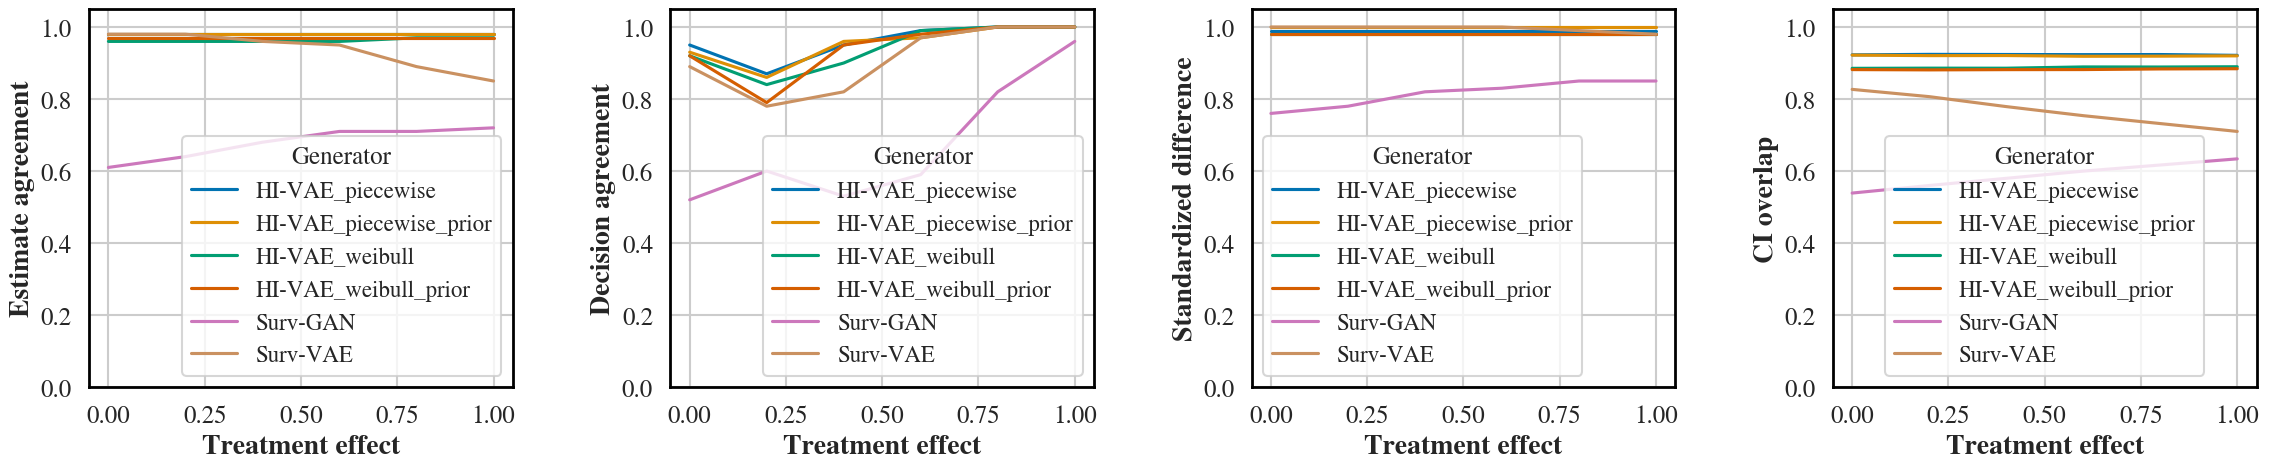

In [22]:
visualize_replicability_te_perf(score_df)

In [23]:
metric_control_df = pd.DataFrame()
for generator_name in generators_sel:
    metric_control_df = pd.concat([metric_control_df, pd.DataFrame(np.array([[generator_name] * results_kmdist_ext.shape[0], 
                                                            results_kmdist_ext["log_pvalue_control_" + generator_name]]).T,
                                                            columns=['generator', 'log_pvalue'])])

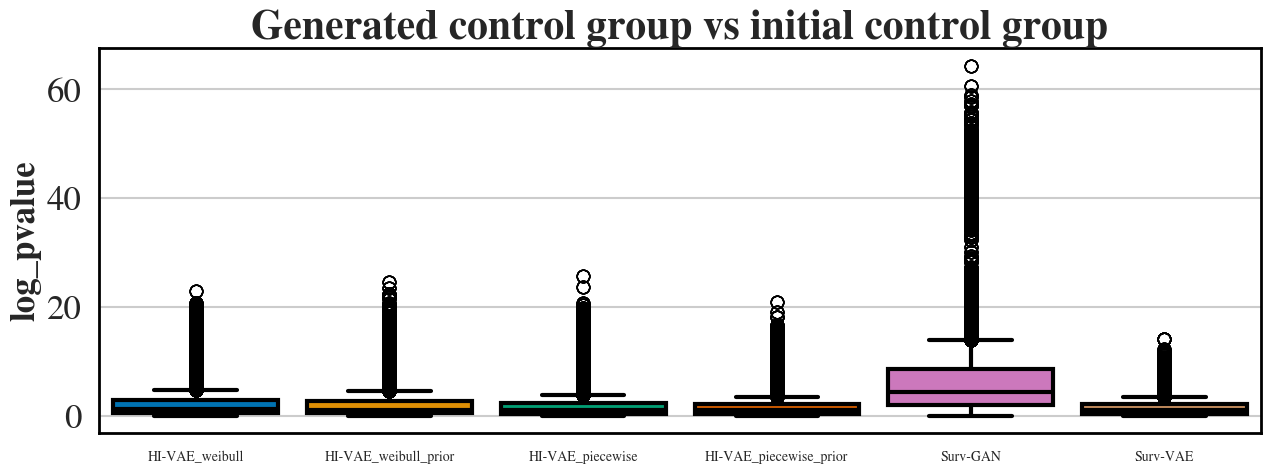

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

metric_control_df['log_pvalue'] = np.float64(metric_control_df['log_pvalue'].values)
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_edgecolor('black')

sns.boxplot(data=metric_control_df, x='generator', y='log_pvalue', ax=ax,
            linewidth = 3, saturation = 1, palette = 'colorblind', 
            width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
ax.set_xlabel('')
ax.set_ylabel('log_pvalue', fontsize=25, fontweight="semibold")
ax.set_title('Generated control group vs initial control group', fontsize=30, fontweight="semibold")
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=25)

In [25]:
methods = [
    'HI-VAE_weibull',
    'HI-VAE_weibull_prior',
    'HI-VAE_piecewise',
    'HI-VAE_piecewise_prior',
    'Surv-GAN',
    'Surv-VAE'
]

# Container for results
results_ext = results_kmdist_ext
rows = []
# Loop over methods
for method in methods:
########################## TODO #############################
###    changer pour log pvalue entre intial control and generated control ###
########################## TODO #############################
    idx = results_ext.groupby('XP_num')["Survival curves distance_"  + method ].idxmin()
    min_rows = results_ext.loc[idx].reset_index(drop=True)
    min_rows['method'] = method
    min_rows['log_pvalue'] = min_rows['log_pvalue_' + method]
    min_rows['est_cox_coef'] = min_rows['est_cox_coef_' + method]
    min_rows['est_cox_coef_se'] = min_rows['est_cox_coef_se_' + method]
    if method != 'init':
        min_rows['J-S distance'] = min_rows['J-S distance_' + method]
        min_rows['KS test'] = min_rows['KS test_' + method]
        min_rows['Survival curves distance'] = min_rows['Survival curves distance_' + method]
        min_rows['Detection XGB'] = min_rows['Detection XGB_' + method]
        min_rows['NNDR'] = min_rows['NNDR_' + method]
        min_rows['K-map score'] = min_rows['K-map score_' + method]
    else :
        min_rows['J-S distance'] = np.nan
        min_rows['KS test'] = np.nan
        min_rows['Survival curves distance'] = np.nan
        min_rows['Detection XGB'] = np.nan 
        min_rows['NNDR'] = np.nan 
        min_rows['K-map score'] = np.nan
    columns_to_keep = [
    'XP_num', 'H0_coef', 'H0_coef_univ','method',
    'log_pvalue',
    'est_cox_coef', 'est_cox_coef_se',
    'J-S distance', 'KS test', 'Survival curves distance',
    'Detection XGB', 'NNDR', 'K-map score']
    min_rows = min_rows[columns_to_keep]
    
    rows.append(min_rows)


# Combine all rows into one DataFrame
results_ext_best = pd.concat(rows, ignore_index=True)

results_ext_best.head()

,XP_num,H0_coef,H0_coef_univ,method,log_pvalue,est_cox_coef,est_cox_coef_se,J-S distance,KS test,Survival curves distance,Detection XGB,NNDR,K-map score
0,0.0,0.0,0.003427,HI-VAE_weibull,1.866441,0.125384,0.088156,0.004574,0.963952,0.028773,0.568018,0.419349,5.0
1,60.0,0.0,0.003427,HI-VAE_weibull,0.824201,-0.069317,0.089506,0.005962,0.960170,0.024186,0.591385,0.455679,7.0
2,120.0,0.0,0.003427,HI-VAE_weibull,1.387756,0.102300,0.088898,0.005944,0.960085,0.026104,0.601414,0.372022,11.0
3,180.0,0.0,0.003427,HI-VAE_weibull,2.492453,0.154591,0.089179,0.006071,0.957778,0.036741,0.580000,0.379786,6.0
4,240.0,0.0,0.003427,HI-VAE_weibull,11.513095,0.399554,0.091026,0.006240,0.956299,0.077419,0.598772,0.395951,3.0


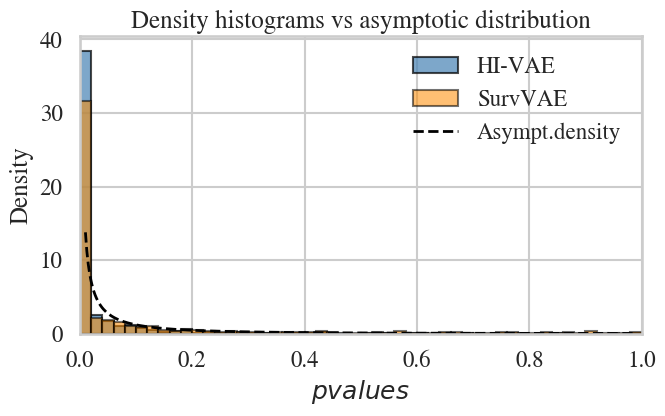

In [26]:
# print(results_ext_best['H0_coef'].unique())
theta = results_ext_best['H0_coef'].unique()[2]
results_kmdist_ext_H0 = results_ext_best[results_ext_best['H0_coef']==theta]
coef_univ = results_kmdist_ext_H0['H0_coef_univ'].to_numpy()[0]    
# --- 1. Data -----------------------------------------------------------
d1 = np.exp(-results_kmdist_ext_H0[results_kmdist_ext_H0['method']=='HI-VAE_weibull']['log_pvalue'])
d2 = np.exp(-results_kmdist_ext_H0[results_kmdist_ext_H0['method']=='Surv-VAE']['log_pvalue'])

# --- 2. Common bin edges (30 bins up to 10, adjust if needed) ----------
x_max = 1
bins  = np.linspace(0, x_max, 51)

# --- 3. Figure ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4.5))

# Histograms as densities
ax.hist(d1, bins=bins, color='steelblue',  edgecolor='black',
        alpha=0.70, label='HI-VAE', density=True)
ax.hist(d2, bins=bins, color='darkorange', edgecolor='black',
        alpha=0.55, label='SurvVAE',density=True)

# --- 4. Overlay Exp(1) density ----------------------------------------
x  = np.linspace(0.01, x_max-0.01, 400)
f,fprime = f_and_fprime(x, coef_univ, 600, 0.85)
ax.plot(x,fprime,lw=2, color='black', ls='--', label=r'Asympt.density')

# --- 5. Cosmetics ------------------------------------------------------
ax.set_xlim(0, x_max)
ax.set_ylim(bottom=0)
ax.set_xlabel(r'$pvalues$')
ax.set_ylabel('Density')
ax.set_title('Density histograms vs asymptotic distribution')
ax.legend(frameon=False)
plt.tight_layout()
plt.show()